In [1]:
%%html
<style>
 p {
    font-size: 17px;
    }
</style>

# **Predicting a Decision in Speed Dating**
## Andrew Chavarria

<div align="center"><img src="https://static01.nyt.com/images/2022/04/28/fashion/26SPEED-DATING1/26SPEED-DATING1-videoSixteenByNine3000.jpg" width=500p></img></div>
<div align="center">Image from The New York Times</div>

# <div align="center"> Introduction </div>

<p>Speed dating is a formalized matchmaking process where two groups of single participants "date" each other for a short period of time, in round-robin fashion. For each date, each participant must decide whether or not they would like to date the other party in the future. If both say "Yes",
then there is a match. </p>
<br>
<p>Assembled by Columbia Business School professors, Ray Fisman and Sheena Iyengar, our <a href="https://www.kaggle.com/datasets/annavictoria/speed-dating-experiment">dataset</a> holds data from speed dating events from 2002-2004. Each participant was required to enter information about themselves, such as age, school of undergraduate degree, and occupation. They were also asked to rate (on a scale of 1-10 or 1-100) what they valued most in a partner. At the end of each date, they were also asked to rate the attributes of their partner on an individual level. Each date was between members of the oppposite sex. There are no entries from same-sex groups.</p>
<br>
<p>In this tutorial, our goal is to find trends in our data, especially comparing the two groups: men and women. By the end of the tutorial, we will have composed a Machine Learning model using a Decision Tree classification algorithm. We hope that by the end of this tutorial, you will have a better understanding of how and why one should handle null entries in a dataset, hypothesis testing, how to create an ML model with SKLearn, and how to evaluate the performance of such a model. </p>

# <div align="center">Data Munging</div>

<p>First, let's import the libraries we need to handle and process our data.</p>

<p>We'll be using <a href="https://pandas.pydata.org/">Pandas</a>, <a href="https://scikit-learn.org/stable/">Scikit-Learn</a>, <a href="https://numpy.org/"> Numpy</a>, and <a href="https://scipy.org/">Scipy</a>:</p>

In [2]:
#import neccessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import tree
from sklearn.model_selection import cross_validate
import scipy.stats as stats

The next step is to acquire the dataset via the internet. You can download the zip file <a href="https://www.kaggle.com/datasets/annavictoria/speed-dating-experiment/download?datasetVersionNumber=1">here</a>.
<br><br>
Now, convert the CSV File into a Pandas DataFrame. Initially, we run into an issue with encoding, because our CSV file is not UTF-8 encoded, so we change the encoding as a parameter passed into read_csv().

In [3]:
data = pd.read_csv("Speed Dating Data.csv", encoding='iso-8859-1')
data.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


Above, you can see that there are 195 columns. 195 potential features in our ML model. Wow, that's a lot of features! It is also easy to see
from the above entries that a lot of the columns have been left empty. That is problematic, because we need real data in order to form our prediction model.

### Data Removal
We will be removing all columns that involve data entries after the participant has already decided whether or not they are a match with their particpant, since this data is irrelevant for the question we want to answer. We want to be able to predict if a person will match with someone solely from the initial speed date they had, and the information about themselves that they filled out prior (such as gender, age, field of study, etc.)

In [4]:
#Remove every column after "amb3_s", since the entries after that are filled out after the speed date event.
data = data.iloc[:, :data.columns.get_loc('satis_2')]

Some columns require altering, particularly for missing data in the columns. There are several ways to handle missing data, and it is context-dependent. For the mn_sat column, which marks the median SAT score from the participant's school for undergrad, we will look up the median score back in 2002 to fill the column. This column is important because it serves as a proxy for overall intelligence.

I manually looked up average SAT score from the school of undergrad that the participants have gone to, and assigned the SAT value in a dictionary. From here, I will fill out the mn_sat score for any participants whose mn_sat was left empty, but have listed their school of undergraduate.

In [5]:
sat_map = {'Washington U. in St. Louis': 1469, 'university of wisconsin/la crosse': 1174 ,'HOWARD UNIVERSITY': 1213, 'Cambridge University': 1480, 'Illinois': 1350, 
       'Penn State University': 1265, 'George Washington University': 1370, 'University of Wisconsin-Madison': 1390, 'University of Illinois/Champaign': 1350, 'GW': 1370,
       'University of Chicago': 1520, 'UC Irvine': 1310, 'Cal State Univ.,Long Beach': 1145, 'Washington University in St. Louis': 1469, 'Tufts University': 1465, 
       'University of Rochester': 1420,  'Rice University': 1505, 'washington university in st louis': 1470, 'Tufts': 1465, 'tufts': 1465, 
       'University of the Philippines': 1026, 'UM': 1355, 'Wake Forest': 1390, 'University of Massachusetts-Amherst': 1290, 'Case Western Reserve University': 1435, 
       'Vanderbilt University': 1505, 'University of Kansas': 1240, 'California State University Los Angeles': 985, 'COOPER UNION': 1413, 'Texas State University': 1095,
       'Cooper Union, Bard college, and SUNY Purchase': 1304, 'University of Genova': 1127, 'Oxford University': 1550, 'Oxford': 1550}

# Fill in all missing SAT scores for schools in which we were able to locate SAT score averages
for k in sat_map.keys():
    data.loc[ data['undergra'] == k, 'mn_sat'] = sat_map[k]

In [6]:
len(data[pd.isna(data.mn_sat) == True])

4671

There are still plenty of missing values for mn_sat, so we will replace these with the median SAT score so far of the participants who have on assigned to them. There is an issue, however. Most of our mn_sat scores are entered as strings, so we will have to convert the entire column to floating point values in order to calculate the median.

In [7]:
# Replace all NaN values with an empty string, set all values in SAT score to strings, then convert all strings to floats for SAT
#so we can calculate median score.
data["mn_sat"] = data['mn_sat'].replace(np.nan, '')
data["mn_sat"]= data["mn_sat"].astype(str)
data["mn_sat"] = pd.to_numeric(data["mn_sat"].replace(',','', regex=True), downcast="float")

# Replace NaN values with the SAT median score of the entire population
data["mn_sat"] = data['mn_sat'].replace(np.nan, data["mn_sat"].median())

Another column we will fill the missing entries of is salary. For this column, we will just calculate the mean salary of all participants and replace all missing salary entries with this mean.

In [8]:
data["income"] = data['income'].replace(np.nan, '')
data["income"]= data["income"].astype(str)
data["income"] = pd.to_numeric(data["income"].replace(',','', regex=True), downcast="float")

data["income"] = data['income'].replace(np.nan, data['income'].mean())

Other columns we will want to remove are the IDs of the participants, IDs of their speed date partner, zipcode, and some of the categorical data that have already been encoded in numbers for us, such as career and field of study in undergrad.

In [9]:
data = data.drop(['iid', 'id', 'idg', 'position', 'positin1', 'partner', 'pid', 'field', 'undergra', 'from', 'zipcode', 'career', 'tuition', 'expnum'], axis = 1)

Now, let's see where we stand:

In [10]:
data.loc[:,['attr5_1', 'sinc5_1', 'intel5_1', 'fun5_1', 'amb5_1']].head()

,attr5_1,sinc5_1,intel5_1,fun5_1,amb5_1
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN


There are still too many NaN entries for our dataset. We will remove the columns who just have too many null entries, at this point:

In [11]:
data = data.iloc[:, :data.columns.get_loc('attr1_s')]
data = data.drop(['attr5_1', 'sinc5_1', 'intel5_1', 'fun5_1', 'amb5_1'], axis = 1)

We will also delete all entries that have missing values in the participant's impression of their date. The ratings of the participant's date are crucial to our prediction, and it wouldn't make sense to replace data with the mean or median of a rating if every person's impression can vary greatly (you may really like a particular person, or really not like them).

In [12]:
# Delete any row with a missing entry in any of these columns
data = data[pd.isna(data.attr) == False]
data = data[pd.isna(data.sinc) == False]
data = data[pd.isna(data.intel) == False]
data = data[pd.isna(data.fun) == False]
data = data[pd.isna(data.amb) == False]
data = data[pd.isna(data.shar) == False]
data = data[pd.isna(data.like) == False]
data = data[pd.isna(data.prob) == False]
data = data[pd.isna(data.met) == False]

Another issue we run into: Out of the 21 waves, waves 6-9 use a rating scale of 1-10 for attributes they are rating, as opposed to an 100-point scale, which is used by all of the other waves. So, we will take each rating from wave 6-9 and multiply it by 10, so it fits an 100-point scale. This is important for replacing nan attribute values with the median/mean of said attribute.
<br><br>
It appears that most attributes have been converted to an 100-point scale for waves 6-9, except attr4_1 to shar4_1, so we will adjust those accordingly:

In [13]:
# Create data mask to get all entries from waves 6-9
mask = ((data['wave'] >=6) & (data['wave'] <= 9))
waves_6_9 = data[mask]
# iterate through each of these rows, and multiply their attribute rating by 10 to fit an 100-point scale
for i, row in waves_6_9.iterrows():
    data.at[i, 'attr4_1'] = waves_6_9['attr4_1'][i]*10
    data.at[i, 'sinc4_1'] = waves_6_9['sinc4_1'][i]*10
    data.at[i, 'intel4_1'] = waves_6_9['intel4_1'][i]*10
    data.at[i, 'fun4_1'] = waves_6_9['fun4_1'][i]*10
    data.at[i, 'amb4_1'] = waves_6_9['amb4_1'][i]*10
    data.at[i, 'shar4_1'] = waves_6_9['shar4_1'][i]*10

Some empty entries cannot be replaced by the mean or median of the column. This is true if the variable is a categorical, such as the race of speed date partner or career choice. So, we will go ahead and delete any empty entries for those attributes.

<br>
<p>Then, we will replace any empty values with the median for the rest of the dataset.</p>

In [14]:
# Delete all rows where entries cannot be replaced by the median. 
not_replaceable = ['race_o', 'met_o', 'field_cd', 'career_c']

for i in not_replaceable:
    data = data[pd.isna(data[i]) == False]
# replace the rest of the columns with their median, if they contain a NaN value:
for col in data.columns:
    data[col] = data[col].replace(np.nan, data[col].median())

In [15]:
for col in data.columns:
    print(col+" empty entry count: "+ str(len(data[pd.isna(data[col])] == True)))

gender empty entry count: 0
condtn empty entry count: 0
wave empty entry count: 0
round empty entry count: 0
order empty entry count: 0
match empty entry count: 0
int_corr empty entry count: 0
samerace empty entry count: 0
age_o empty entry count: 0
race_o empty entry count: 0
pf_o_att empty entry count: 0
pf_o_sin empty entry count: 0
pf_o_int empty entry count: 0
pf_o_fun empty entry count: 0
pf_o_amb empty entry count: 0
pf_o_sha empty entry count: 0
dec_o empty entry count: 0
attr_o empty entry count: 0
sinc_o empty entry count: 0
intel_o empty entry count: 0
fun_o empty entry count: 0
amb_o empty entry count: 0
shar_o empty entry count: 0
like_o empty entry count: 0
prob_o empty entry count: 0
met_o empty entry count: 0
age empty entry count: 0
field_cd empty entry count: 0
mn_sat empty entry count: 0
race empty entry count: 0
imprace empty entry count: 0
imprelig empty entry count: 0
income empty entry count: 0
goal empty entry count: 0
date empty entry count: 0
go_out empty entr

There are no more empty entries in our dataset! Phew, that was a lot of work. Now we can begin to explore the data...

# <div align="center"> Exploring the Data </div>

To begin our exploratory analysis, we will break the data into two separate groups: Male and Female. We could have chosen other ways to separate groups, such as age or race. But it makes intuitive sense to classify based on gender, since the two different groups being paired in the speed dating experiment were male and female.

In [16]:
# Create two new dataframes from our data, distinguishing between male and female.
female_df = data[data['gender'] == 0]
male_df = data[data['gender'] == 1]

Now let's answer some questions with our given dataframes. For example, are women and men equally as selective when deciding whether or not they want to see someone again after a date?

To begin to answer this question, we will want to know what information we need. Our number of males and females are roughly equivalent (slightly more males), so we may be able to answer our own question with a simple data visualization, if the difference is stark enough. We will plot this on a bar graph using Matplotlib.

In [17]:
# Get the decisions of males and females for "Yes" and "No" for the dec attribute, and put into an array
male_dec = [male_df['dec'].value_counts()[0], male_df['dec'].value_counts()[1]]
female_dec = [female_df['dec'].value_counts()[0], female_df['dec'].value_counts()[1]]

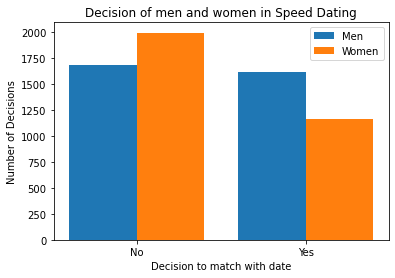

In [18]:
#X-axis array
X = ['No', 'Yes']

X_axis = np.arange(len(X))
  
#create bar for men and women
plt.bar(X_axis - 0.2, male_dec, 0.4, label = 'Men')
plt.bar(X_axis + 0.2, female_dec, 0.4, label = 'Women')

# Set the parameters for the bar graph, such as labeling and title, then display.
plt.xticks(X_axis, X)
plt.xlabel("Decision to match with date")
plt.ylabel("Number of Decisions")
plt.title("Decision of men and women in Speed Dating")
plt.legend()
plt.show()

Interesting, despite a slightly larger amount of men, more women than men decide "No", and are also far less likely to say "yes". Men are nearly 50/50 in their decision split. It is clear that women were a bit more choosy than men, on average, in our dataset.

### Creating a Decision Tree Model

Since we are also making a classification  model, we will want to save the data and targets for the respective dataframes, for later.
<br>
We will get the input of decisions from the participants in the form of an array, and then remove the targets from the dataset, since we are using our ML model to decide whether the participant will decide "yes" or "no".

In [19]:
#Collect the respective data and targets according to gender:
female_target = np.array(female_df.dec)
female_data = female_df.drop('dec', axis = 1)
female_X, female_y = female_data.to_numpy(), female_target


male_target = np.array(male_df.dec)
male_data = male_df.drop('dec', axis = 1)
male_X, male_y = male_data.to_numpy(), male_target

# Data and target for whole dataframe
target = np.array(data.dec)
data = data.drop('dec', axis = 1)
X, y = data.to_numpy(), target

### Fitting and testing our model
For each of the data and its targets, we can fit a Decision Tree, and then run 10-fold cross validation (with SKLearn) to estimate the skill of our new model.
<br>

Our performance metrics chosen will be accuracy, recall, and precision of our test data, in order to give an all-around impression of just how well it performs. We will also compute the mean squared error, to report Cross Validation error for our algorithm. The lower the MSE, the better.

<br>

Each cross-validation produces each of these scores, so we will take the mean of all 10.

<br>


In [20]:
clf = tree.DecisionTreeClassifier(max_depth = 10, splitter = 'best', criterion = "entropy")
female_clf = clf.fit(female_X, female_y)

from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score

scoring = {'mse':'neg_mean_squared_error', 'acc': 'accuracy', 'prec_macro': 'precision_macro','rec_macro': make_scorer(recall_score, average='macro')}
scores = cross_validate(clf, female_X, female_y, scoring=scoring, cv=10, return_train_score=True)

print("Female Test data performance: ")
print("10-fold Cross Validation results for Decision Tree on the entire dataset:")
print("%0.2f accuracy for test data" % (np.mean(scores['test_acc'])))
print("%0.2f recall for test data" % (np.mean(scores['test_rec_macro'])))
print("%0.2f precision for test data" % (np.mean(scores['train_prec_macro'])))
print("%0.2f mean_squared error for test data" % (np.mean(scores['test_mse'])))
print("\nFemale Training data performance: ")
print("10-fold Cross Validation results for Decision Tree on the entire dataset:")
print("%0.2f accuracy for test data" % (np.mean(scores['train_acc'])))
print("%0.2f recall for test data" % (np.mean(scores['train_rec_macro'])))
print("%0.2f precision for test data" % (np.mean(scores['train_prec_macro'])))
print("%0.2f mean_squared error for training data" % (np.mean(scores['train_mse'])))

Female Test data performance: 
10-fold Cross Validation results for Decision Tree on the entire dataset:
0.81 accuracy for test data
0.81 recall for test data
0.95 precision for test data
-0.19 mean_squared error for test data

Female Training data performance: 
10-fold Cross Validation results for Decision Tree on the entire dataset:
0.96 accuracy for test data
0.95 recall for test data
0.95 precision for test data
-0.04 mean_squared error for training data


In [21]:
clf = tree.DecisionTreeClassifier(max_depth = 10, splitter = 'best', criterion = "entropy")
male_clf = clf.fit(male_X, male_y)

scoring = {'mse':'neg_mean_squared_error', 'acc': 'accuracy', 'prec_macro': 'precision_macro','rec_macro': make_scorer(recall_score, average='macro')}
scores = cross_validate(clf, male_X, male_y, scoring=scoring, cv=10, return_train_score=True)

print("Male Test data performance: ")
print("10-fold Cross Validation results for Decision Tree on the entire dataset:")
print("%0.2f accuracy for test data" % (np.mean(scores['test_acc'])))
print("%0.2f recall for test data" % (np.mean(scores['test_rec_macro'])))
print("%0.2f precision for test data" % (np.mean(scores['train_prec_macro'])))
print("%0.2f mean_squared error for test data" % (np.mean(scores['test_mse'])))
print("\nMale Training data performance: ")
print("10-fold Cross Validation results for Decision Tree on the entire dataset:")
print("%0.2f accuracy for test data" % (np.mean(scores['train_acc'])))
print("%0.2f recall for test data" % (np.mean(scores['train_rec_macro'])))
print("%0.2f precision for test data" % (np.mean(scores['train_prec_macro'])))
print("%0.2f mean_squared error for training data" % (np.mean(scores['train_mse'])))

Male Test data performance: 
10-fold Cross Validation results for Decision Tree on the entire dataset:
0.80 accuracy for test data
0.80 recall for test data
0.94 precision for test data
-0.20 mean_squared error for test data

Male Training data performance: 
10-fold Cross Validation results for Decision Tree on the entire dataset:
0.94 accuracy for test data
0.94 recall for test data
0.94 precision for test data
-0.06 mean_squared error for training data


In [22]:
clf = tree.DecisionTreeClassifier(max_depth = 10, splitter = 'best', criterion = "entropy")
clf = clf.fit(X, y)

scoring = {'mse':'neg_mean_squared_error', 'acc': 'accuracy', 'prec_macro': 'precision_macro','rec_macro': make_scorer(recall_score, average='macro')}
scores = cross_validate(clf, X, y, scoring=scoring, cv=10, return_train_score=True)

print("Males and Females Combined Test data performance: ")
print("10-fold Cross Validation results for Decision Tree on the entire dataset:")
print("%0.2f accuracy for test data" % (np.mean(scores['test_acc'])))
print("%0.2f recall for test data" % (np.mean(scores['test_rec_macro'])))
print("%0.2f precision for test data" % (np.mean(scores['train_prec_macro'])))
print("%0.2f mean_squared error for test data" % (np.mean(scores['test_mse'])))
print("\nMales and Females Combined Training data performance: ")
print("10-fold Cross Validation results for Decision Tree on the entire dataset:")
print("%0.2f accuracy for test data" % (np.mean(scores['train_acc'])))
print("%0.2f recall for test data" % (np.mean(scores['train_rec_macro'])))
print("%0.2f precision for test data" % (np.mean(scores['train_prec_macro'])))
print("%0.2f mean_squared error for training data" % (np.mean(scores['train_mse'])))

Males and Females Combined Test data performance: 
10-fold Cross Validation results for Decision Tree on the entire dataset:
0.85 accuracy for test data
0.85 recall for test data
0.93 precision for test data
-0.15 mean_squared error for test data

Males and Females Combined Training data performance: 
10-fold Cross Validation results for Decision Tree on the entire dataset:
0.93 accuracy for test data
0.93 recall for test data
0.93 precision for test data
-0.07 mean_squared error for training data


Our Decision Tree models for males and females perform worse at predicting decisions after a date, as opposed to taking the entire dataset as a whole. Why is this? It could be minor overfitting, since our training data performs about 10% better on accuracy and recall when compared to the training data for males and females. Remember, we are cutting our cutting our training data in half when we split dateframes into male and female.



This makes sense, because when we use the dataframe combining both males and females, we are creating more training data for the model, which improves the test data performan ce and results in less overfitting in the Tree.

### Tuning Hyperparameters
SKLearn contains several hyperparameters for the DecisionTreeClassifier to create a Decision Tree, such as max_features, min_weight_fraction_leaf, min_samples_split, and many more. To keep our model relatively simple for beginners, we will tune the max_depth (how deep our tree recurses down), to show differences in model performance.

In [23]:
clf = tree.DecisionTreeClassifier(max_depth = 20, splitter = 'best', criterion = "entropy")
clf = clf.fit(X, y)

scoring = {'mse':'neg_mean_squared_error', 'acc': 'accuracy', 'prec_macro': 'precision_macro','rec_macro': make_scorer(recall_score, average='macro')}
scores = cross_validate(clf, X, y, scoring=scoring, cv=10, return_train_score=True)

print("Males and Females Combined Test data performance with max_depth of 20: ")
print("10-fold Cross Validation results for Decision Tree on the entire dataset:")
print("%0.2f accuracy for test data" % (np.mean(scores['test_acc'])))
print("%0.2f recall for test data" % (np.mean(scores['test_rec_macro'])))
print("%0.2f precision for test data" % (np.mean(scores['train_prec_macro'])))
print("%0.2f mean_squared error for test data" % (np.mean(scores['test_mse'])))
print("\nMales and Females Combined Training data performance with max_depth of 20: ")
print("10-fold Cross Validation results for Decision Tree on the entire dataset:")
print("%0.2f accuracy for test data" % (np.mean(scores['train_acc'])))
print("%0.2f recall for test data" % (np.mean(scores['train_rec_macro'])))
print("%0.2f precision for test data" % (np.mean(scores['train_prec_macro'])))
print("%0.2f mean_squared error for training data" % (np.mean(scores['train_mse'])))

Males and Females Combined Test data performance with max_depth of 20: 
10-fold Cross Validation results for Decision Tree on the entire dataset:
0.83 accuracy for test data
0.82 recall for test data
1.00 precision for test data
-0.17 mean_squared error for test data

Males and Females Combined Training data performance with max_depth of 20: 
10-fold Cross Validation results for Decision Tree on the entire dataset:
1.00 accuracy for test data
1.00 recall for test data
1.00 precision for test data
-0.00 mean_squared error for training data


Take for example above, where we set our Decisiom Tree max_depth to 20 for the entire datset. This improved our training set performance to 100% for several metrics, including a 0.0 MSE, but our test set performance suffered, suggesting overfitting. With hyperparameters, it is important to tune them to reach acceptable rates of performance. Unfortunately, tuning hyperparameters is not an exact science and can require trial-and-error. I did several trial-and-error to pick a good max_depth prior to this tutorial, and a value of 10 seemed to do well for all sets.

### Making sense of Feature Importance in a Decision Tree model
We know what a Decision Tree decides to split nodes at is relatively simple; it takes a greedy approach by splitting at the feature with the highest "purity", or least entropy among the other features to split at in order to make a decision. This gives use the highest information gain.


**Algorithm**:
<br>
    while(features_remaining!=null):<br>
        &nbsp;&nbsp;&nbsp;&nbsp;next_split = least_entropy(features_remaining)<br>
        &nbsp;&nbsp;&nbsp;&nbsp;featurs_remaining.remove(next_split)<br><br>

**Entropy**: 
<br>
<img src = "https://www.baeldung.com/wp-content/ql-cache/quicklatex.com-004399bf736b5463087bdd15d256e30e_l3.svg" width=300p></img>
<br>*Image from baeldung.com*
<br>

Scikit learn's Decision Tree classifier has an attribute, *feature_importances_*, which returns an array of each feature's importance for the model, normalized. Let's take the top five important features for men and women when making a decision, and see how they compare.

In [24]:
# get Tree model feature_importances_ array
male_feature_arr = male_clf.feature_importances_
# Map the name of the feature to its importance within the feature_importances_ array
male_dict = dict()
index = 0
for col in male_data.columns:
    male_dict[col] = male_feature_arr[index]
    index+=1
# Sort the importance in ascending order
male_arr = sorted(male_dict.items(), key=lambda x: x[1])

# Repeat the same process for females:
female_feature_arr = female_clf.feature_importances_
female_dict = dict()
index = 0
for col in female_data.columns:
    female_dict[col] = female_feature_arr[index]
    index+=1
female_arr = sorted(female_dict.items(), key=lambda x: x[1])

# Extract the top 5 most important attributes for males and females when making a decision
male_attributes_top5 = [i[0] for i in male_arr[-5:]]
female_attributes_top5 = [i[0] for i in female_arr[-5:]]

Now, we can create a barplot comparing importance of attribute for each gender. In our case, the top five attributes were all the same, though the importance value was different between genders.

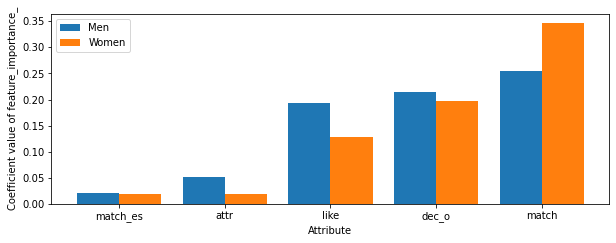

In [25]:
plt.rcParams["figure.figsize"] = [10, 3.50]
X_axis = np.arange(len(male_attributes_top5))
plt.bar(X_axis- 0.2 , [i[1] for i in male_arr[-5:]], 0.4, label = 'Men')
X_axis = np.arange(len(female_attributes_top5))
plt.bar(X_axis+ 0.2 , [i[1] for i in female_arr[-5:]], 0.4, label = 'Women')
plt.xticks(X_axis, male_attributes_top5)
plt.xlabel("Attribute")
plt.ylabel("Coefficient value of feature_importance_")
plt.legend()
plt.show()

Attractiveness of the partner appears to be a better predictor of a decision for men than it does for women. The same is true for how much the person "likes" their date. Interestingly enough, the best predictors for a decision are based on the decision of the person's date, and whether or not their was a match. 

## <div align="center">Hypothesis Testing</div>

We will create a new column in our dataset, difference_of_age, which takes the difference in age between the participant and their date.

In [26]:
# Create new column, 'difference_of_age', and initialize with value 0 for all rows.
data['difference_of_age'] = 0
# For each row, calculate the difference in age between the participant and their date.
for i, row in data.iterrows():
    data.at[i, 'difference_of_age'] = data['age_o'][i] - data['age'][i]

In [27]:
print("Mean difference in age between any date: "+str(data['difference_of_age'].mean()))
print("Mean difference in age between matched dates: "+str(data[data['match'] == 1]['difference_of_age'].mean()))

Mean difference in age between any date: 0.06799876084262702
Mean difference in age between matched dates: 0.10053859964093358


The mean difference in age is larger between matched dates, but is it statistically significant?

### Checking normal distribution

Now we need to check if our data is normally distributed to see if we can perform a T-Test to compare two different groups here. The two differing groups being the normal populatiom, and those who matched with their date. 

Text(0, 0.5, 'Number of dates')

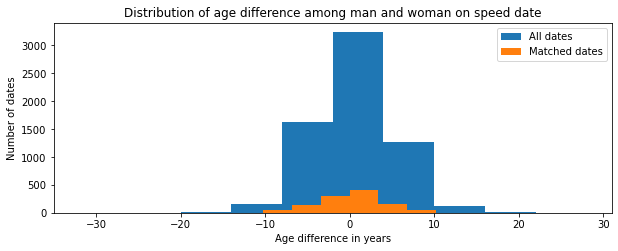

In [28]:
fig, ax = plt.subplots()
#assign histogram bar to all dates
ax.hist(data['difference_of_age'], 10, label='All dates', stacked=True)
#assign histogram bar to matched dates
ax.hist(data[data['match'] == 1]['difference_of_age'], 10, label='Matched dates', stacked=True)
# Make the chart look pretty
ax.legend()
ax.set_title("Distribution of age difference among man and woman on speed date")
ax.set_xlabel("Age difference in years")
ax.set_ylabel("Number of dates")

Both of the groups seem to have a relatively normal distribution for difference in age. We can perform the Two-Sample T-Test, using Scipy's library, to compute the P-value. 

In [29]:
# Run t-test, using Scipy, on the different groups
stats.ttest_ind(data['difference_of_age'], data[data['match'] == 1]['difference_of_age'])

Ttest_indResult(statistic=-0.21816494784320625, pvalue=0.8273064769725224)

The P-Value is not <= 0.05, so the difference in age is not statistically significant between dates that match, compared to all dates. 

<div align="center"><img src="https://i0.wp.com/post.psychcentral.com/wp-content/uploads/sites/4/2022/01/couple-silhouette-sunset-holding-hands-walking-grass-1296x728-header-1024x575.jpg?w=1155&h=1528" width=500p></div>
<div align="center">Copyright: Westend61 / Ezequiel Giménez</div>

## <div align="center">Conclusion</div>

Dating and romance can seem complicated and confusing. Using data science, my hope was that this exploration would make the dating world easier to understand. Obviously, love is more complex than numbers, and it is difficult to capture what makes two people click, when everyone is so different. That said, our ML model was able to create a prediction that was better than 50/50 guessing when predicting if someone would like to see another person again, or not. 

So what should someone take away from our findings? I think it is worth thinking about that whether a match existed, or if the other person said "yes" too were hands-down the best predictors of a "Yes" or a "No". It perhaps suggests that people are able to read each other and have an intutive sense of whether or not they get along with someone else. If you are ever unsure of your relationship standing with someone else, or had a bad date experience with them, then chances are, they may feel the same way. And the same goes for positive experiences. Our findings do allude to differences in dating preferences between men and women too. There are several other studies exploring the differences, and our findings do seem to fit those of the other studies, such as larger emphasis placed on phyiscial attractiveness for men as opposed to women.

Our exploration has much room for improvement. There are several different factors that are still left to explore, such as relationships between matches and differences in intellgience or income. And for rigorous statistical analysis, one should keep in mind to control for other variables to make their findings as precise and accurate as possible. Machine learning can be a powerful tool in reading social dynamics, but newer, fuller, datsets are hopefully available in the near future so we can try and make sense of the world through the patters and relationships it reveals to us.